# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. 

For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Data collect

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [3]:

key = "TV1WC9ANR799K1H1"

import requests
import csv
from tqdm import tqdm

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["Open", "High", "Low", "Close", "Volume"]
    df['Date'] = date
    return df

In [4]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

# cv1 = request_stock_price_list('IBM', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data.csv')

# Data Preprocessing

Then the datasets are loaded

In [5]:
# For data preprocessing and analysis part
# data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
# data = pd.read_csv('data\\NASDAQ\\abe.us.txt')
# 读取时只要Date和Close
data = pd.read_csv('data\\NASDAQ\\abe.us.txt', usecols=["Date","Close"])
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
# data = pd.read_csv('./data/data.csv',index_col=0)
# Any CSV or TXT file can be added here....
print(data.size)
data.head()


6380


,Date,Close
0,2005-02-25,6.5753
1,2005-02-28,6.6263
2,2005-03-01,6.6072
3,2005-03-02,6.5816
4,2005-03-03,6.5944


In [6]:
data.isnull().sum()

Date     0
Close    0
dtype: int64

Filling null columns with mean values....

In [7]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Date,Close
0,2005-02-25,6.5753
1,2005-02-28,6.6263
2,2005-03-01,6.6072
3,2005-03-02,6.5816
4,2005-03-03,6.5944


The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [8]:
df = data

In [9]:
from sklearn.model_selection import train_test_split
close_column = df['Close']
X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = close_column[i]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((close_column[i + j] - first) / first)
    temp2.append((close_column[i + window_size] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2470
618


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [10]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
62/62 [==============================] - 5s 21ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0853 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0456
Epoch 2/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0455 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0380
Epoch 3/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0414 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0359
Epoch 4/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0388 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0335
Epoch 5/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0375 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0319
Epoch 6/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0346 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0340
Epoch 7/40
62/62 [=========

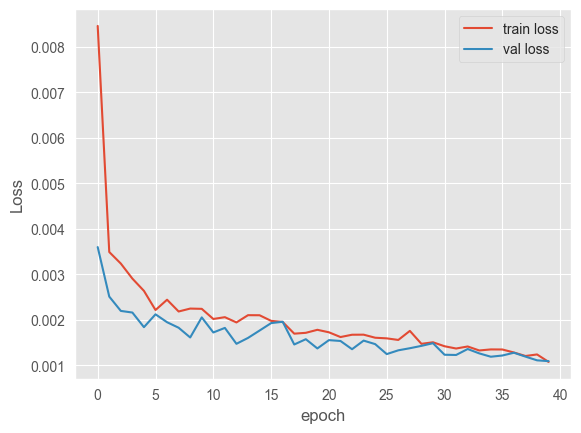

In [11]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

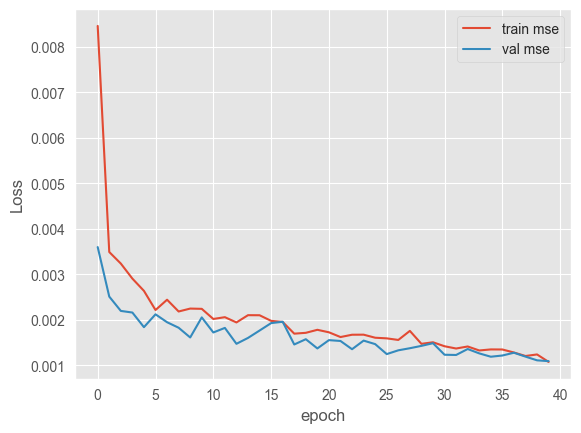

In [12]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

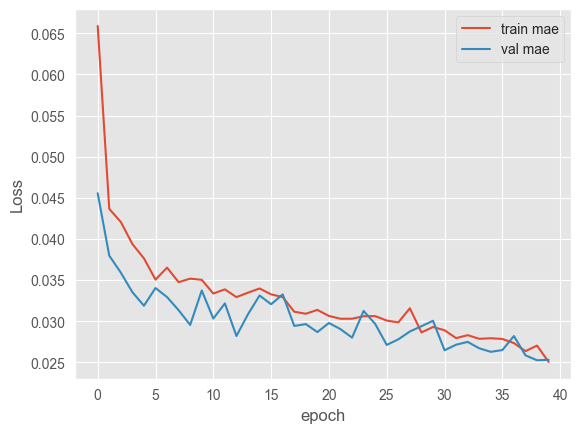

In [13]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [14]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 98, 64)         256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 47, 128)        24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 23, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 21, 64)         24640     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 10, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 640)            0

## 测试集表现

In [15]:
model.evaluate(test_X, test_Y)

 1/20 [>.............................] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0313

20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0253


[0.0010909131960943341, 0.0010909131960943341, 0.025306295603513718]

In [16]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.952487
R2 Score: 0.952487
Max Error: 0.140972


In [17]:
predicted_pre  = model.predict(test_X)
test_label_pre = test_Y.reshape(-1,1)
predicted_pre = np.array(predicted_pre[:,0]).reshape(-1,1)
close_column = data['Close']
test_label_raw = np.zeros(len(test_label_pre))
predicted_raw = np.zeros(len(predicted_pre))
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = close_column[j]
    test_label_raw[j - len_t] = test_label_pre[j - len_t] * temp + temp
    predicted_raw[j - len_t] = predicted_pre[j - len_t] * temp + temp

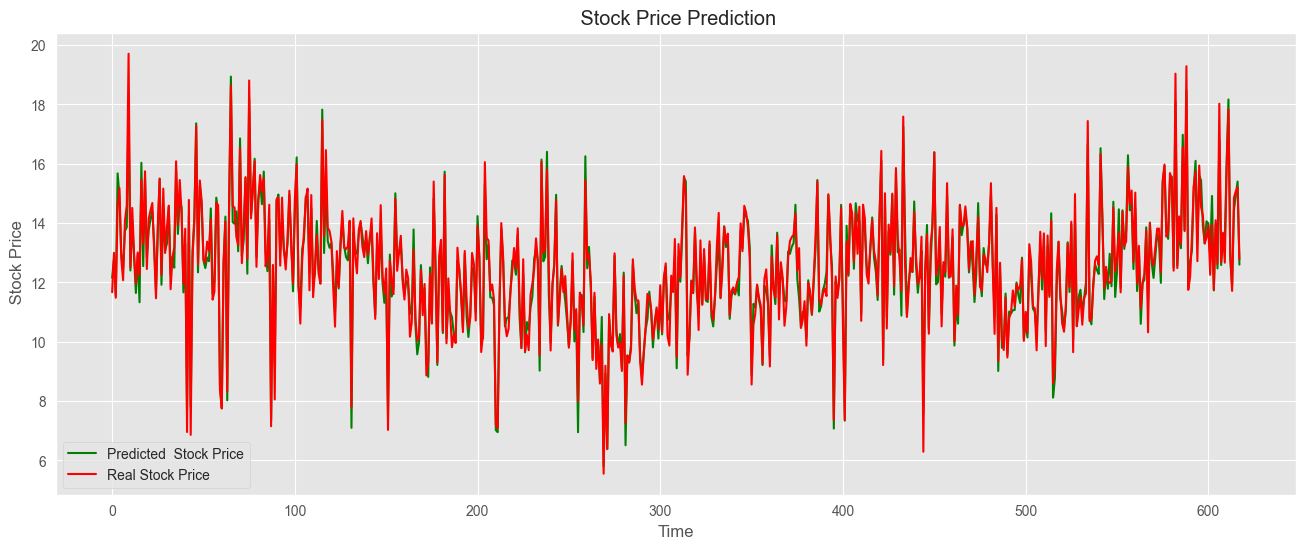

In [18]:

plt.figure(figsize=(16,6))
plt.plot(predicted_raw, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label_raw, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [19]:
# First we need to save a model
model.save("model.h5")

In [20]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [21]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 98, 64)         256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 47, 128)        24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 23, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 21, 64)         24640     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 10, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 640)            0

In [22]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data/data.csv',names=['open','high','low','close','volume','date'],index_col=0,header=0)
# Any CSV or TXT file can be added here....

# 数据预处理
data2.dropna(inplace=True)
data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)

# 去除日期
df2 = data2.drop('date', axis=1)

X = []
Y = []
close_column = df2['close']
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = close_column[i]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((close_column[i + j] - first) / first)
    # for j in range(week):
    temp2.append((close_column[i + window_size] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

4776
1194


In [23]:
model.evaluate(test_X, test_Y)

 1/38 [..............................] - ETA: 0s - loss: 5.7972e-04 - mse: 5.7972e-04 - mae: 0.0209

38/38 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0615   


[0.006717715412378311, 0.006717715412378311, 0.061492133885622025]

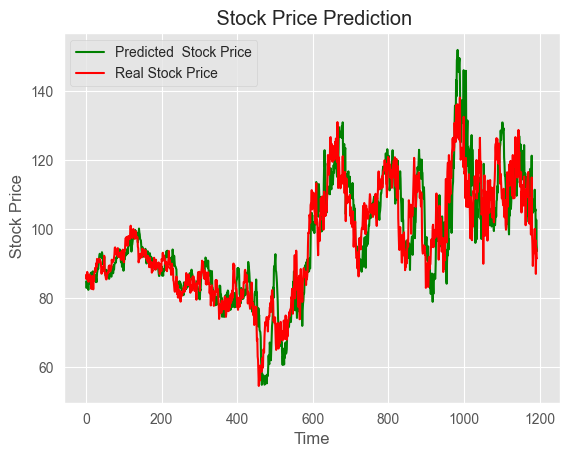

In [24]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()